The purpose of this notebook is to show how to **calibrate and integrate** XRD data using pyFAI library.

See pyFAI tutorial here: (https://www.youtube.com/watch?v=j0cphX3z2mM&ab_channel=ESRFsynchrotron)
See pyFAI documents here: (https://pyfai.readthedocs.io/en/stable/)

At 28ID-2-D-tomo beamline endstation of NSLS-II, we mainly use two different area detectors:

* PerkinElmer : https://resources.perkinelmer.com/corporate/pdfs/downloads/bro_digitalxraydetectors.pdf
* Dexela 2923 : https://www.sciencedirect.com/science/article/pii/S0168900212006730



# general imports

In [3]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time

import numpy as np
import xarray as xr


from IPython.display import clear_output


In [4]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)
try:
    import ipympl
except:
    !!pip install ipympl
    import ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

try:
    import PyQt5
except:
    !!pip install PyQt5

try:
    import pyFAI
except:
    !!pip install pyfai
    import pyFAI

In [5]:
%matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# setting up the example data path

In [7]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace XXX with the exact path where this notebook (000.read_research_data_into_python.ipynb)
# and its data folder (000.read_research_data_into_python.data) is.

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except Exception as exc:
    print(exc)
    os.chdir('.')

No module named 'google.colab'


In [8]:
# Assuming 002.learn_pyFAI.data folder is here.

here = os.getcwd()
example_data_path = '002.learn_pyFAI.data'

# navigate into example_data_path directory
os.chdir(example_data_path)

os.listdir('.')

['.DS_Store',
 'from_PerkinElmer_detector',
 '.ipynb_checkpoints',
 'from_Dexela2923_detector']

# Re-calibration of a diffraction image with Jupyter

In [10]:
# from_PerkinElmer_detector folder has calibration.poni file with content below:
%cat from_PerkinElmer_detector/calibration.poni

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Tue Dec  5 17:23:16 2023
poni_version: 2
Detector: Perkin
Detector_config: {"pixel1": 0.0002, "pixel2": 0.0002}
Distance: 1.4280177479893559
Poni1: 0.23398429857415295
Poni2: 0.37634908408057827
Rot1: -0.003994332959290178
Rot2: -0.026132616520970278
Rot3: -4.71036871681453e-10
Wavelength: 1.814e-11


In [11]:
# Create a "normal" azimuthal integrator from provided calibration poni file
ai_provided = pyFAI.load('from_PerkinElmer_detector/calibration.poni')
ai_provided

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428018e+00 m	PONI= 2.339843e-01, 3.763491e-01 m	rot1=-0.003994  rot2=-0.026133  rot3=-0.000000 rad
DirectBeamDist= 1428.517 mm	Center: x=1910.265, y=983.288 pix	Tilt= 1.515° tiltPlanRotation= -81.312° 𝛌= 0.181Å

\
Here we will re-calibrate the detector geometry by following pyFAI tutorials \

* https://pyfai.readthedocs.io/en/latest/usage/tutorial/Recalib/Recalib_notebook.html
* https://www.silx.org/doc/pyFAI/latest/usage/cookbook/calibration_with_jupyter.html



In [13]:
from pyFAI.gui import jupyter
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.gui.jupyter.calib import Calibration
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 2024.2.0


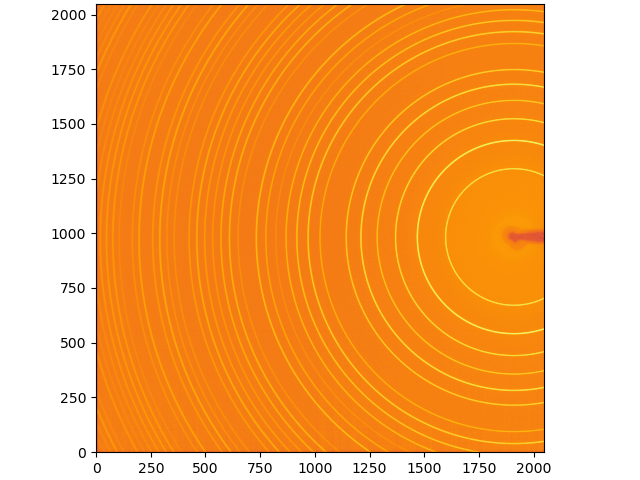

In [14]:
# this loads a tiff file using fabio package that is installed by pyFAI
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data

fig = plt.figure()
ax = fig.add_subplot()
jupyter.display(img,ax=ax);

In [15]:
# Definition of the detector and of the calibrant:
detector  = pyFAI.detector_factory("Perkin Elmer")
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = 0.1814*1e-10 # wavelength is usually provided by the beamline scientist

calib = Calibration(img, calibrant=calibrant, wavelength=calibrant.wavelength, detector=detector)

# 1. Set the ring number (0-based value), below the plot
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Restart at 1. for at least a second ring
# 4. Click refine to launch the calibration.

In [16]:
# This is the calibrated geometry:

%matplotlib inline

gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

None
Fixed parameters: ['wavelength', 'rot3']


AttributeError: 'NoneType' object has no attribute 'chi2'

In [ ]:
# re-extract all control points using the "massif" algorithm
calib.extract_cpt()

In [ ]:
# This is the geometry with all rings defined:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

In [ ]:
# Create a azimuthal integrator (without fitting capabilities from the geometry-refinement object)
ai_recalibrated = pyFAI.load(gr)
ai_recalibrated

In [ ]:
# Display the integrated data to validate the calibration.
# Note that calibration with provided (from_PerkinElmer_detector/calibration.poni)
# is almost same as the re-calibrated one. Therefore, blue and orange is very similar.

from matplotlib.pyplot import subplots
fig, ax = subplots(1, 1, figsize=(10, 5), dpi=128)
jupyter.plot1d(ai_provided.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='with provided calibration')

jupyter.plot1d(ai_recalibrated.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='re-calibrated')

ax.set_xlim([1,16])
ax.set_ylim(bottom=8)
ax.set_yscale('log')

In [ ]:
# as expected, the difference between ai_provided and ai_recalibrated is small
print(ai_provided)
print('\n\n')
print(ai_recalibrated)

# Integrating images with azimuthal integrator (ai) object

In [17]:
# As explained in the previous section, we can read ai through a provided poni file or generate it by performing a calibration.
# A third option is to define it as in the following


ai_dict = {
    'detector_name':"Perkin Elmer",
    'wavelength':1.814000e-11,
    'detector_dist':1.4280177479893559,
    'detector_poni1':0.23398429857415295,
    'detector_poni2':0.37634908408057827,
    'detector_rot1':-0.003994332959290178,
    'detector_rot2':-0.026132616520970278,
    'detector_rot3':-4.71036871681453e-10,
    'ai_from':'20240122-191827_step_scan_uid=4d94f1ef__LaB6.nc'
}
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai = AzimuthalIntegrator(
    detector=ai_dict['detector_name'],
    wavelength=ai_dict['wavelength'],
    dist=ai_dict['detector_dist'],
    poni1=ai_dict['detector_poni1'],
    poni2=ai_dict['detector_poni2'],
    rot1=ai_dict['detector_rot1'],
    rot2=ai_dict['detector_rot2'],
    rot3=ai_dict['detector_rot3'],
)

ai

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428018e+00 m	PONI= 2.339843e-01, 3.763491e-01 m	rot1=-0.003994  rot2=-0.026133  rot3=-0.000000 rad
DirectBeamDist= 1428.517 mm	Center: x=1910.265, y=983.288 pix	Tilt= 1.515° tiltPlanRotation= -81.312° 𝛌= 0.181Å

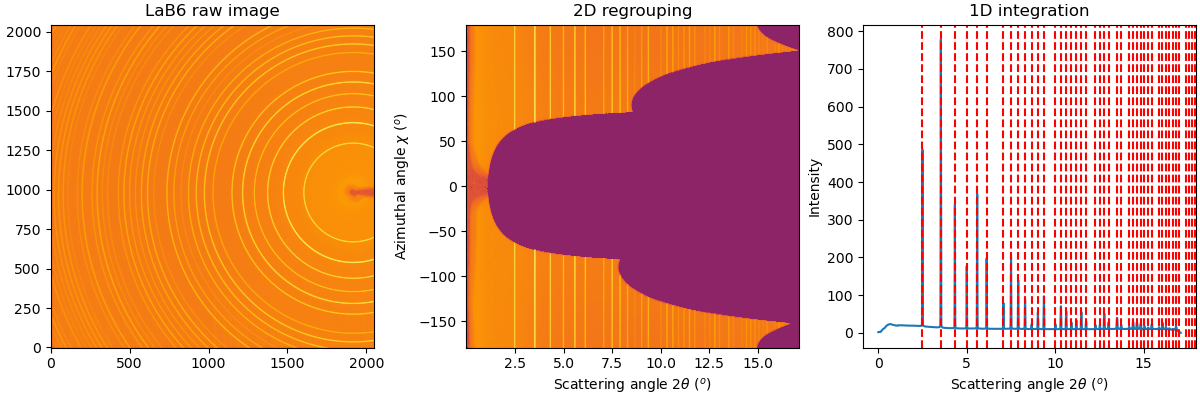

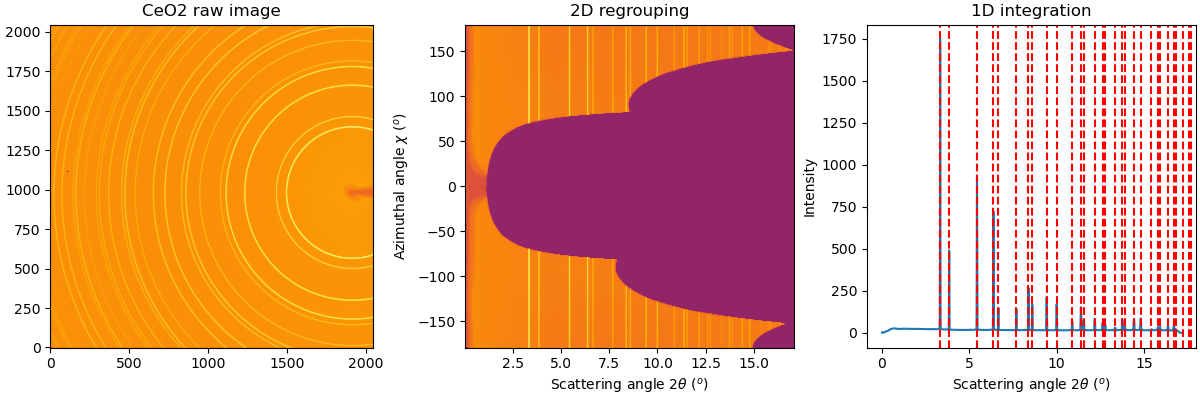

In [19]:
# for LaB6
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = ai.wavelength


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('LaB6 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);



# for CeO2
img = fabio.open("from_PerkinElmer_detector/CeO2.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("CeO2")
calibrant.wavelength = ai.wavelength

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('CeO2 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);

# Applying mask for the integration.

/var/folders/fv/f3rjvg351299n28859b4n45m0000gq/T/ipykernel_18492/2218593258.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


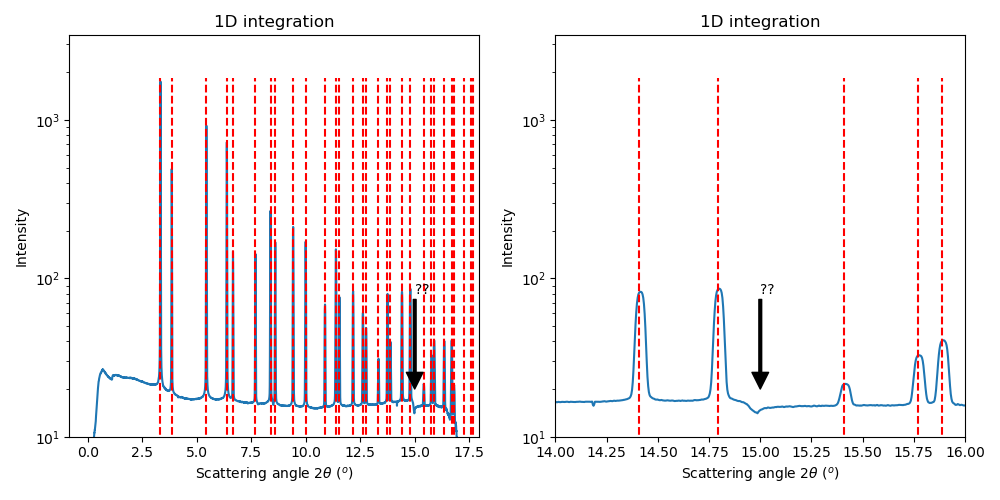

In [22]:
# If you look closely, there are some weird kings in the spectrum.
# They are coming from detector artefacts and beamstop and we need to mask them.

fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(1,2,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

ax = fig.add_subplot(1,2,2)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

In [24]:
# You can create a mask by running "pyFAI-drawmask" utilty that comes with pyFAI.
# Below is a screenshot from that. Once mask is done, you can save it as edf and use as shown in next cell.

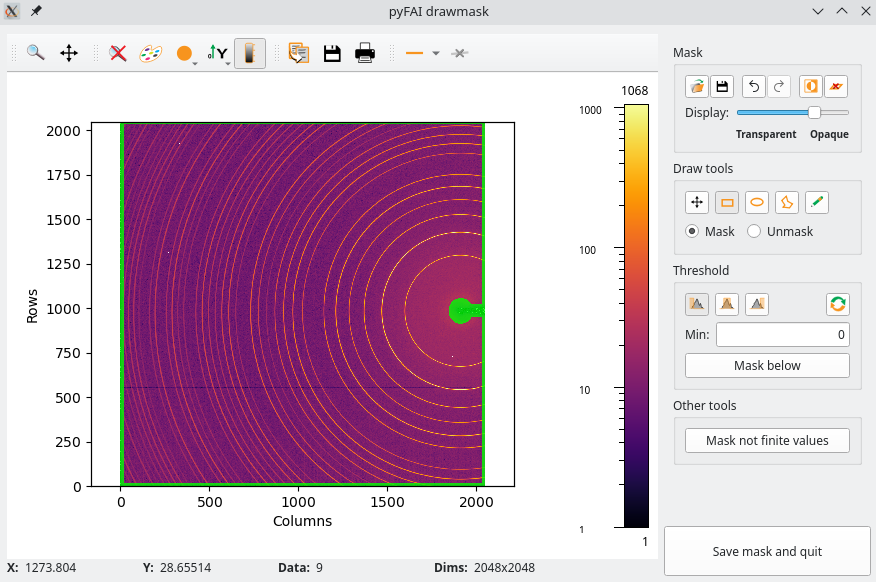
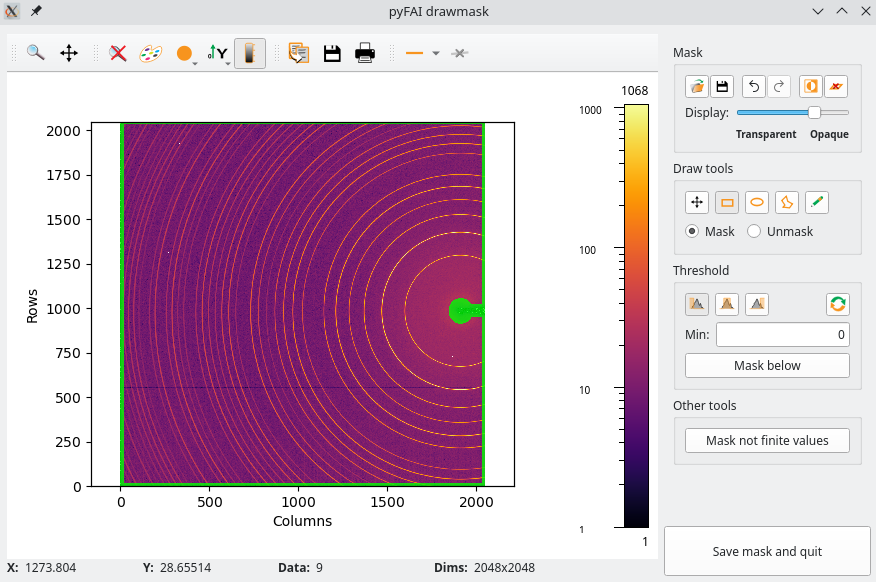

/var/folders/fv/f3rjvg351299n28859b4n45m0000gq/T/ipykernel_18492/581852274.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


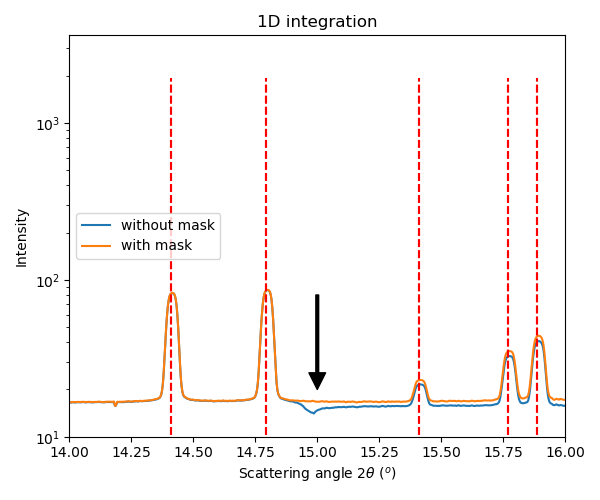

In [27]:
# load mask
mask = fabio.open("from_PerkinElmer_detector/LaB6_mask.edf").data

# then use
i1d_with_mask = ai.integrate1d(img, mask=mask, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile


fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax,label='without mask');
jupyter.plot1d(i1d_with_mask,calibrant=calibrant,ax=ax,label='with mask');

ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

# Exporting integrated 1d profile for subsequent analysis or plotting

In [30]:
# Exporting is straightforward. You just need to add filename='xxx' to the integrator
i1d = ai.integrate1d(img, mask=mask,
                     npt=5000, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

In [32]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

# {
#     "poni_version": 2.1,
#     "detector": "Perkin",
#     "detector_config": {
#         "pixel1": 0.0002,
#         "pixel2": 0.0002,
#         "orientation": 3
#     },
#     "dist": 1.4280177479893559,
#     "poni1": 0.23398429857415295,
#     "poni2": 0.37634908408057827,
#     "rot1": -0.003994332959290178,
#     "rot2": -0.026132616520970278,
#     "rot3": -4.71036871681453e-10,
#     "wavelength": 1.814e-11
# }
# Mask applied: user provided
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> from_PerkinElmer_detector/LaB6.xy
#       2th_deg             I 
  5.321716e-01    2.843087e+01
  5.354483e-01    2.845259e+01
  5.387251e-01    2.830423e+01
  5.420019e-01    2.840915e+01
  5.452786e-01    2.853591e+01
  5.485554e-01    2.863363e+01
  5.518321e-01    2.857040e+01
  5.551089e-01    2.860401e+01
  5.583857e-01    2.876107e+01
  5.616624e-01    2.887814e+01
  5.649392e-01    2.888148e+01
  5.682159e-01 

In [34]:
# if we don't want header lines in the exported xy file, we can export it using np.savetxt as below.

out = np.column_stack( (i1d.radial, i1d.intensity) )
np.savetxt('from_PerkinElmer_detector/LaB6.xy',out,fmt=' %.4e  %.4e')

In [36]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

 5.3217e-01  2.8431e+01
 5.3545e-01  2.8453e+01
 5.3873e-01  2.8304e+01
 5.4200e-01  2.8409e+01
 5.4528e-01  2.8536e+01
 5.4856e-01  2.8634e+01
 5.5183e-01  2.8570e+01
 5.5511e-01  2.8604e+01
 5.5839e-01  2.8761e+01
 5.6166e-01  2.8878e+01
 5.6494e-01  2.8881e+01
 5.6822e-01  2.8929e+01
 5.7149e-01  2.8949e+01
 5.7477e-01  2.8971e+01
 5.7805e-01  2.8953e+01
 5.8132e-01  2.8901e+01
 5.8460e-01  2.8887e+01
 5.8788e-01  2.8847e+01
 5.9115e-01  2.8759e+01
 5.9443e-01  2.8737e+01
 5.9771e-01  2.8782e+01
 6.0098e-01  2.8899e+01
 6.0426e-01  2.8918e+01
 6.0754e-01  2.8887e+01
 6.1081e-01  2.8982e+01
 6.1409e-01  2.9028e+01
 6.1737e-01  2.9108e+01
 6.2064e-01  2.9165e+01
 6.2392e-01  2.9331e+01
 6.2720e-01  2.9410e+01
 6.3047e-01  2.9464e+01
 6.3375e-01  2.9444e+01
 6.3703e-01  2.9448e+01
 6.4030e-01  2.9425e+01
 6.4358e-01  2.9511e+01
 6.4686e-01  2.9615e+01
 6.5013e-01  2.9679e+01
 6.5341e-01  2.9753e+01
 6.5669e-01  2.9760e+01
 6.5997e-01  2.9760e+01


In [38]:
# there exist more options for ai.integrate1d.
# see docstring below

ai.integrate1d?

Signature:
ai.integrate1d(
    data,
    npt,
    filename=None,
    correctSolidAngle=True,
    variance=None,
    error_model=None,
    radial_range=None,
    azimuth_range=None,
    mask=None,
    dummy=None,
    delta_dummy=None,
    polarization_factor=None,
    dark=None,
    flat=None,
    method=('bbox', 'csr', 'cython'),
    unit=q_nm^-1,
    safe=True,
    normalization_factor=1.0,
    metadata=None,
)
Docstring:
Calculate the azimuthal integration (1d) of a 2D image.

Multi algorithm implementation (tries to be bullet proof), suitable for SAXS, WAXS, ... and much more
Takes extra care of normalization and performs proper variance propagation.

:param ndarray data: 2D array from the Detector/CCD camera
:param int npt: number of points in the output pattern
:param str filename: output filename in 2/3 column ascii format
:param bool correctSolidAngle: correct for solid angle of each pixel if True
:param ndarray variance: array containing the variance of the data.
:param str err

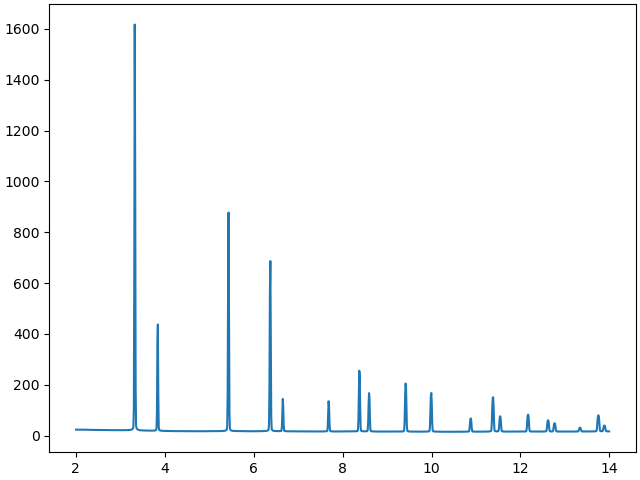

In [40]:
# For example, if we want to limit radial range from 2 to 14 with 1200 points, we can do it like this:

i1d = ai.integrate1d(img, mask=mask, radial_range = (2,14),
                     npt=1200, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

data = np.loadtxt('from_PerkinElmer_detector/LaB6.xy',unpack=True)
plt.figure()
plt.plot(data[0],data[1])

# Applying median filter to remove bad pixels.

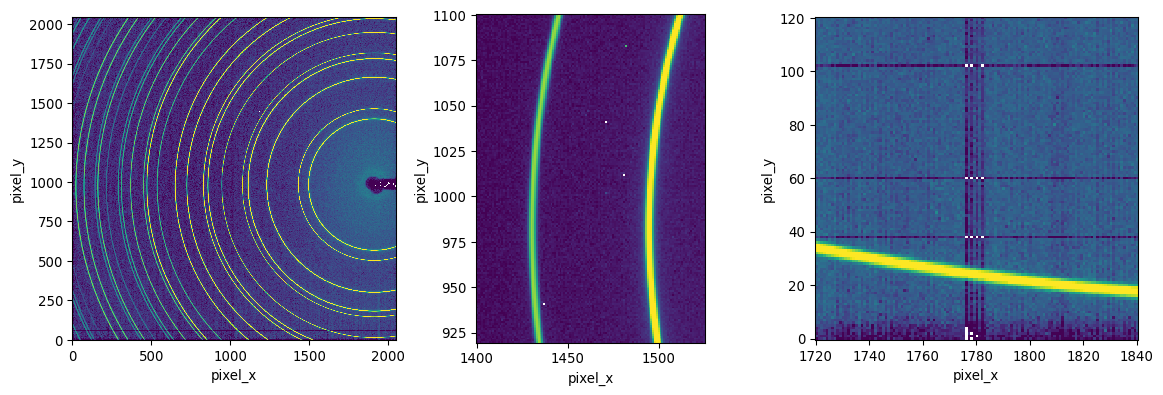

In [55]:
# xarray's plotting tools will help us to see easier

%matplotlib inline

img = fabio.open("from_PerkinElmer_detector/CeO2.tiff").data

da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure(dpi=96,figsize=(12,4))

ax = fig.add_subplot(1,3,1)
np.log(da).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
np.log(da.sel(pixel_x=slice(1400,1525)).sel(pixel_y=slice(920,1100))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
np.log(da.sel(pixel_x=slice(1720,1840)).sel(pixel_y=slice(0,120))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

In [45]:
"""
find a way to get rid of these white spots in the image
"""

'\nfind a way to get rid of these white spots in the image\n'

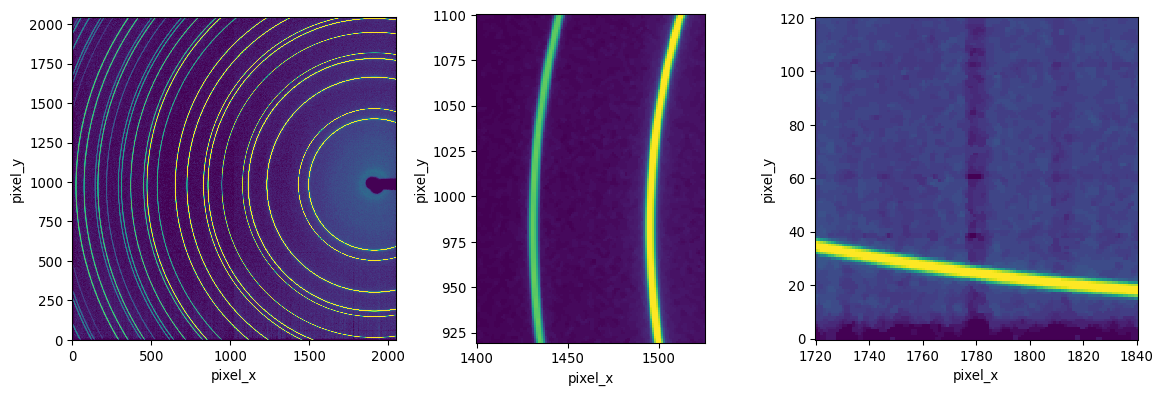

In [59]:
img = scipy.ndimage.median_filter(img, size=3)
da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure(dpi=96,figsize=(12,4))

ax = fig.add_subplot(1,3,1)
np.log(da).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
np.log(da.sel(pixel_x=slice(1400,1525)).sel(pixel_y=slice(920,1100))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
np.log(da.sel(pixel_x=slice(1720,1840)).sel(pixel_y=slice(0,120))).plot.imshow(ax=ax,robust=True,add_colorbar=False) 
ax.set_aspect('equal')